# DeiT models analysis

Import all the necessary libraries

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torchvision
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from models_v2 import *
from src.plots import *

/opt/anaconda3/envs/fact/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


## DEIT-III pre-trained - artifacts visualization

#### Choose DeiT version (size)

In [2]:
model_size = "small"

if model_size == "tiny":
    chosen_model = deit_tiny_patch16_LS(
        pretrained=True, img_size=384, pretrained_21k=True
    )
elif model_size == "small":
    chosen_model = deit_small_patch16_LS(
        pretrained=True, img_size=384, pretrained_21k=True
    )
elif model_size == "base":
    chosen_model = deit_base_patch16_LS(
        pretrained=True, img_size=384, pretrained_21k=True
    )
elif model_size == "large":
    chosen_model = deit_large_patch16_LS(
        pretrained=True, img_size=384, pretrained_21k=True
    )
else:
    raise ValueError("Invalid model size: choose from 'tiny', 'small', 'base', 'large'")

******************** PRETRAINED 21k MODEL WILL BE USED


In [3]:
print("Chosen model:", model_size.upper())
chosen_model

Chosen model: SMALL


vit_models(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x Layer_scale_init_Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,

#### Choose an image for the analysis

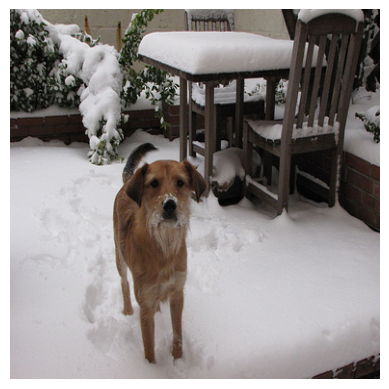

In [4]:
image_path = "./images/dog.JPEG"
img = get_image(image_path)
plot_image(img.squeeze(0))

In [5]:
# final output shape
chosen_model(img).shape

torch.Size([1, 1000])

### Artifacts visualization

Norm of feature values after MLP


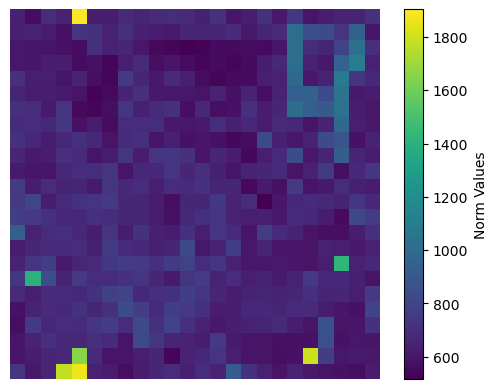

Norm of CLS token:  541.15045


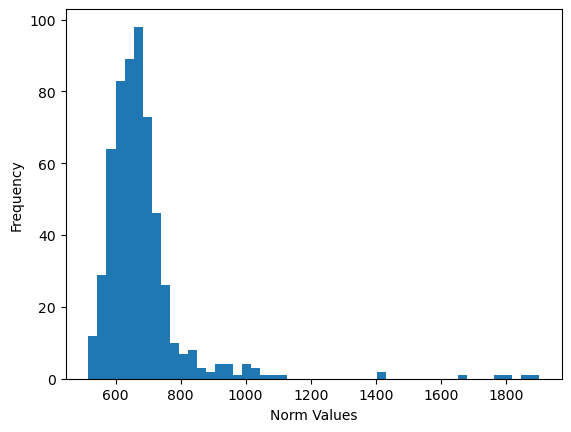

All attention maps


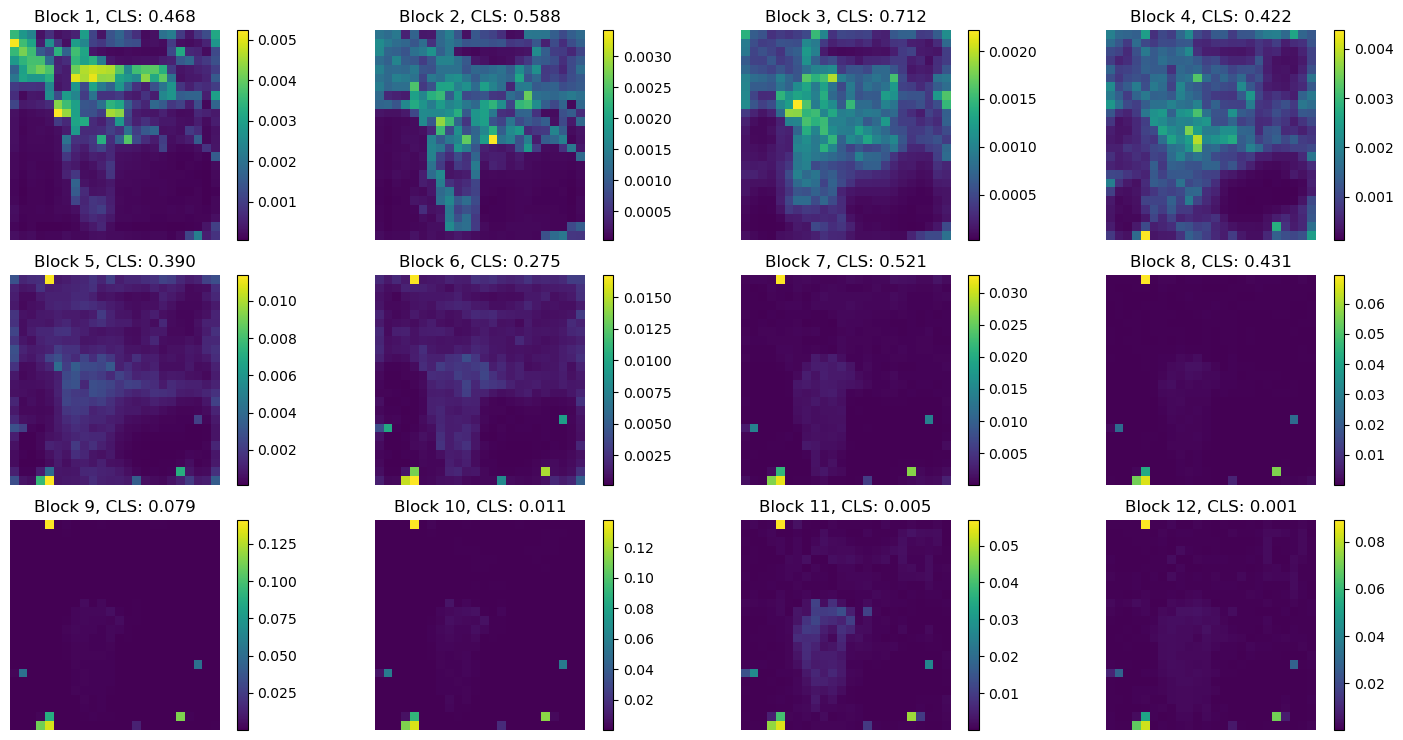



All norm maps


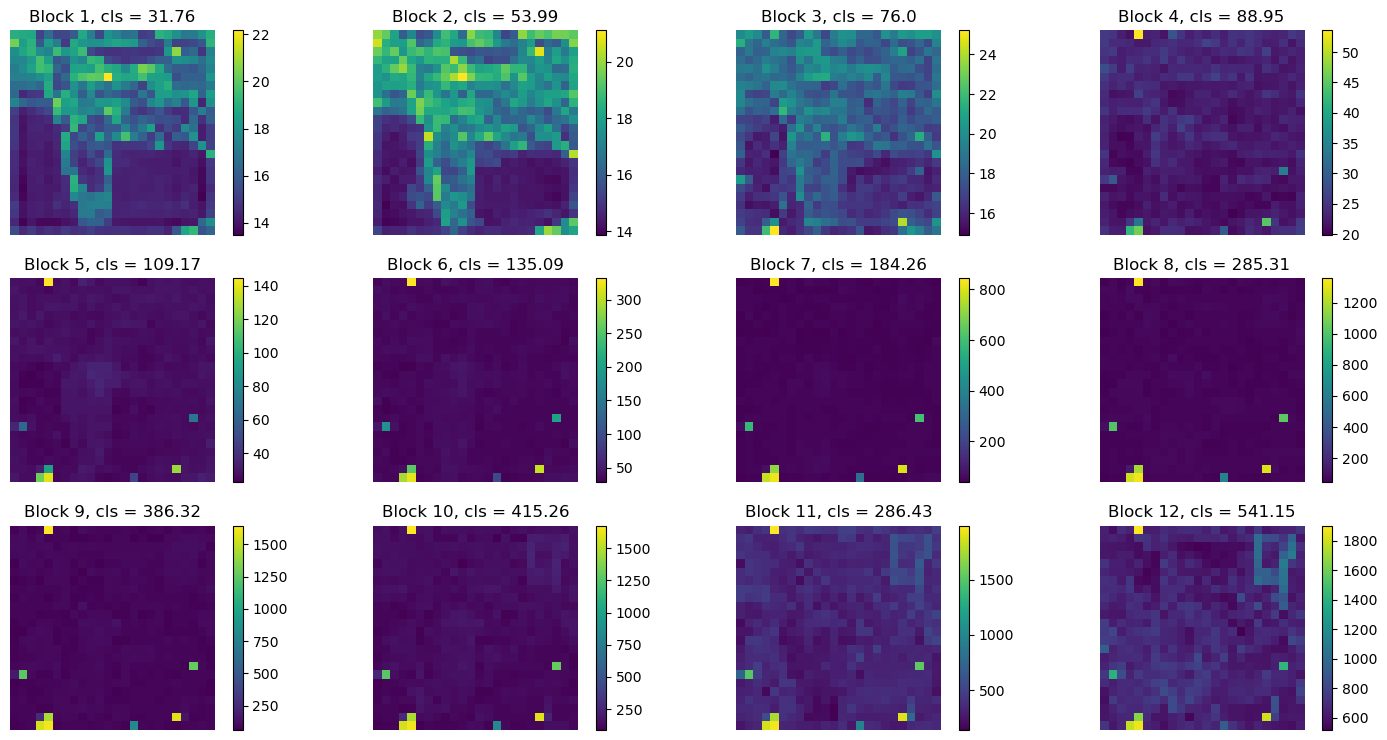

In [6]:
show_artifacts(test_model=chosen_model, test_image=img, log_scale=True, token = 0)

### TODO: clarify (High-Attention Patches with Local Feature Norms)

(576, 576)
(1, 577, 384)
(24, 24)
Mean norm for high-attention patches: 685.130859375


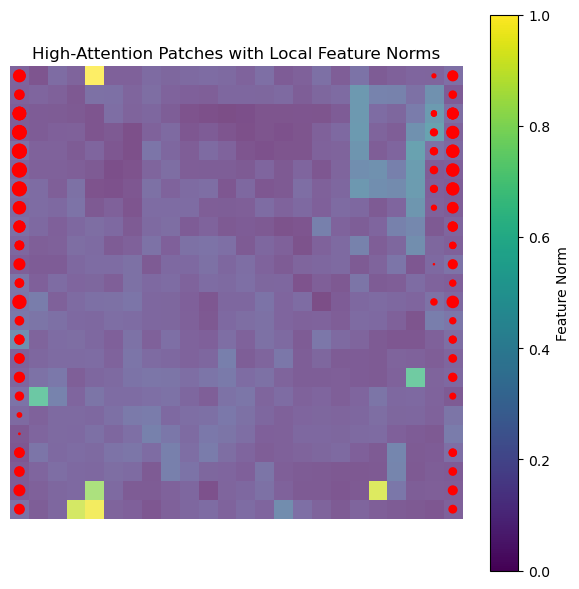

In [7]:
combined_attention = chosen_model.blocks[11].attn.attn_map.squeeze(0).mean(dim=0)[1:, 1:].detach().numpy()
print(combined_attention.shape)
print(chosen_model.block_output["block11"].detach().numpy().shape)

local_feature_norms = (
    chosen_model.block_output["block11"]
    .squeeze(0)
    .norm(dim=-1)[1:]
    .reshape(24, 24)
    .detach()
    .numpy()
)
print(local_feature_norms.shape)

################################################################################

high_attention_threshold = np.percentile(combined_attention, 99.9)
high_attention_indices = np.where(combined_attention >= high_attention_threshold)

scale_factor = 24
scaled_attention_indices = (
    high_attention_indices[0] // scale_factor,
    high_attention_indices[1] // scale_factor,
)

attention_values = combined_attention[high_attention_indices]

high_attention_norms = local_feature_norms[scaled_attention_indices]

mean_high_attention_norm = np.mean(high_attention_norms)
print(f"Mean norm for high-attention patches: {mean_high_attention_norm}")

dot_sizes = (
    (attention_values - np.min(attention_values))
    / (np.max(attention_values) - np.min(attention_values))
    * 100
)

plt.figure(figsize=(6, 6))
plt.imshow(local_feature_norms, cmap="viridis", alpha=0.7)
plt.scatter(
    scaled_attention_indices[1], scaled_attention_indices[0], color="red", s=dot_sizes
)
plt.title("High-Attention Patches with Local Feature Norms")
plt.axis("off")
plt.colorbar(label="Feature Norm")
plt.tight_layout()
plt.show()

### Top norm tokens vs. their attention values
Find the intersection of high-norm and high-attention tokens from a selected attention block (last by default) and visualize it

In [8]:
def top_norm_tokens(test_model: nn.Module, block: int = None) -> np.ndarray:
    """Get sorted tokens with the highest norm values from the last block"""
    if block is None:
        block = len(test_model.blocks) - 1

    output = test_model.block_output["block" + str(block)]
    # output = output.squeeze(0)
    output = output[:, 1:]
    output_norms = output.norm(dim=-1)
    top_tokens = torch.argsort(output_norms, descending=True, dim=1)

    return top_tokens.cpu().numpy()


def top_attn_tokens(test_model: nn.Module, block: int = None) -> np.ndarray:
    """Get sorted tokens with the highest attention values from the last block"""
    if block is None:
        block = len(test_model.blocks) - 1
    attn_map_mean = test_model.blocks[block].attn.attn_map.mean(dim=1)
    top_tokens = torch.argsort(attn_map_mean[:, 0, 1:], descending=True)
    return top_tokens.cpu().numpy()


def find_high_norm_attn_intersection(test_model: nn.Module, block: int = None, top_n: int = 10) -> np.ndarray:
    """Find the intersection of top tokens with the highest norm and attention values"""
    intersection = []
    top_norm = top_norm_tokens(test_model, block)[:, :top_n]
    top_attn = top_attn_tokens(test_model, block)[:, :top_n]

    for i in range(top_norm.shape[0]):
        intersection.append(np.intersect1d(top_attn[i], top_norm[i]))
    return intersection

In [9]:
top10_attn_tokens = top_attn_tokens(chosen_model)[:, :10]
print(top10_attn_tokens)

top20_attn_tokens = top_attn_tokens(chosen_model)[:, :20]
print(top20_attn_tokens)

intersection = find_high_norm_attn_intersection(chosen_model)
print(intersection)

[[  4 556 547 555 532 409 405 408 548 566]]
[[  4 556 547 555 532 409 405 408 548 566 250 299 248 249 274 272 251 271
  295 391]]
[array([  4, 405, 409, 532, 547, 555, 556])]


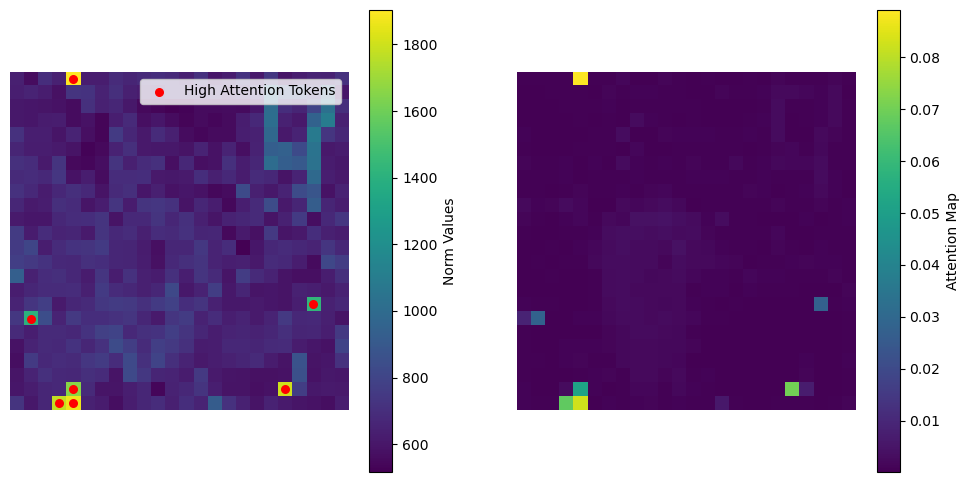

In [10]:
# NOTE: I think we should stick to the top 10/20 high-attention tokens, cause taking the intersection is kinda cheating 😬
plot_feature_norms_with_high_attn(
    chosen_model=chosen_model,
    output_tensor=chosen_model.block_output["block11"],
    high_attn_tokens=intersection,
)

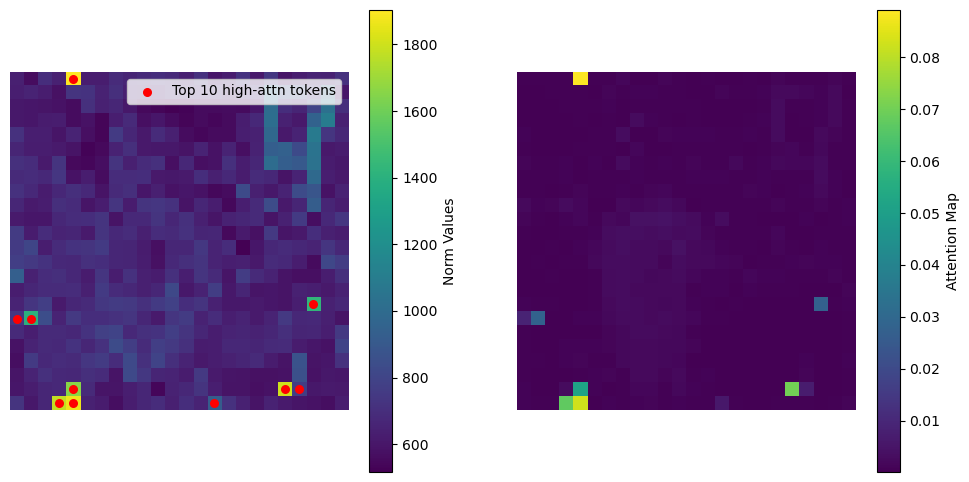

In [11]:
plot_feature_norms_with_high_attn(
    chosen_model=chosen_model,
    output_tensor=chosen_model.block_output["block11"],
    high_attn_tokens=top10_attn_tokens,
    label="Top 10 high-attn tokens",
)

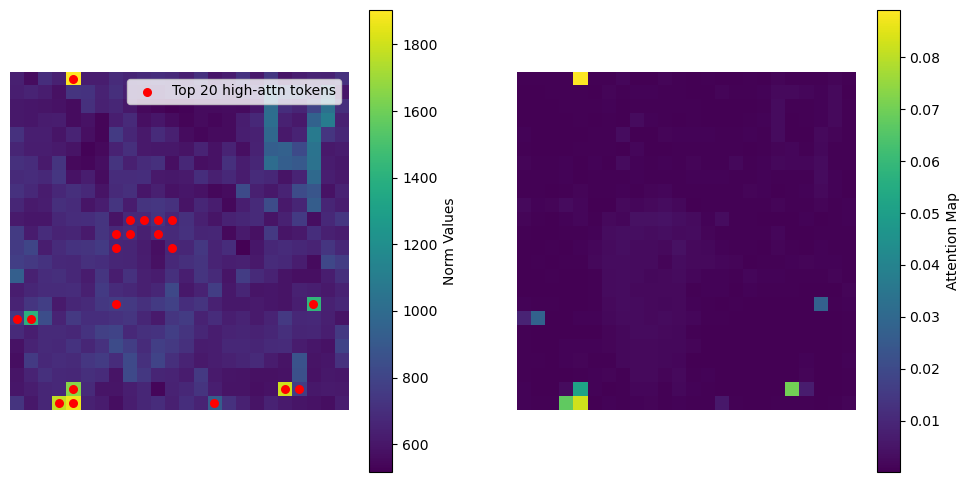

In [12]:
plot_feature_norms_with_high_attn(
    chosen_model=chosen_model,
    output_tensor=chosen_model.block_output["block11"],
    high_attn_tokens=top20_attn_tokens,
    label="Top 20 high-attn tokens",
)

### Check attention values of selected tokens across all blocks

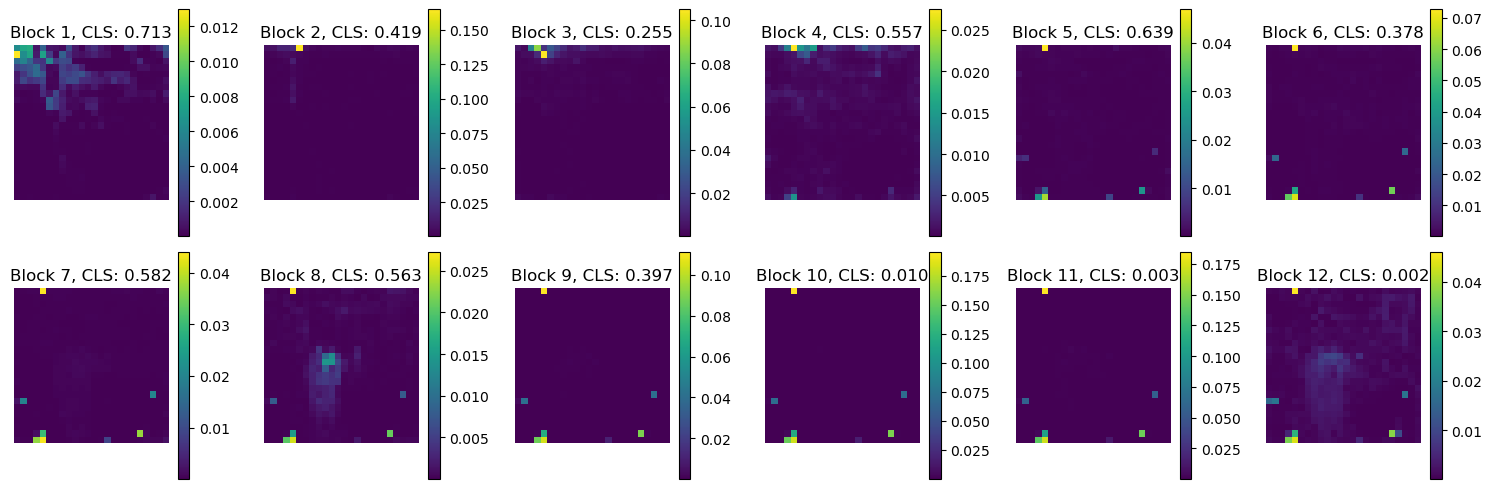

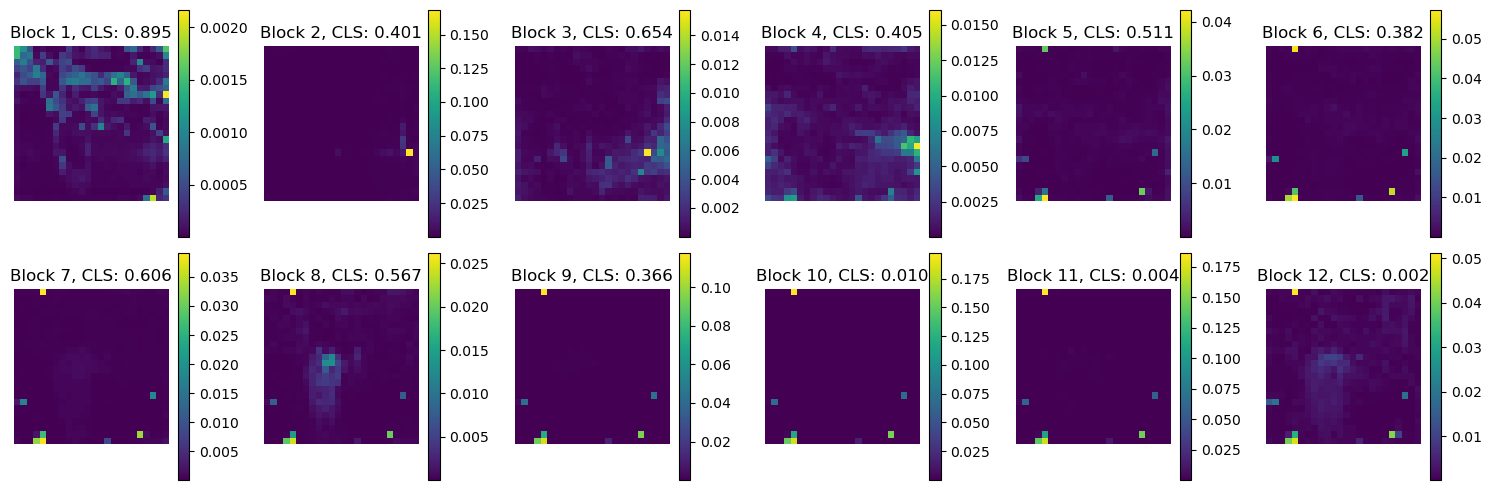

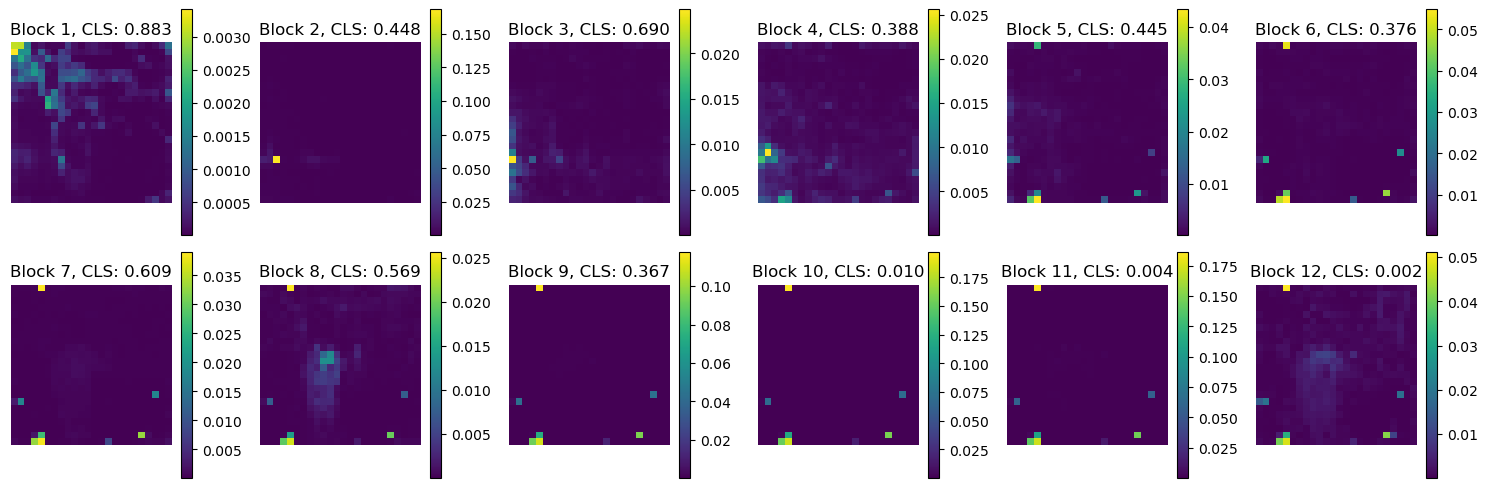

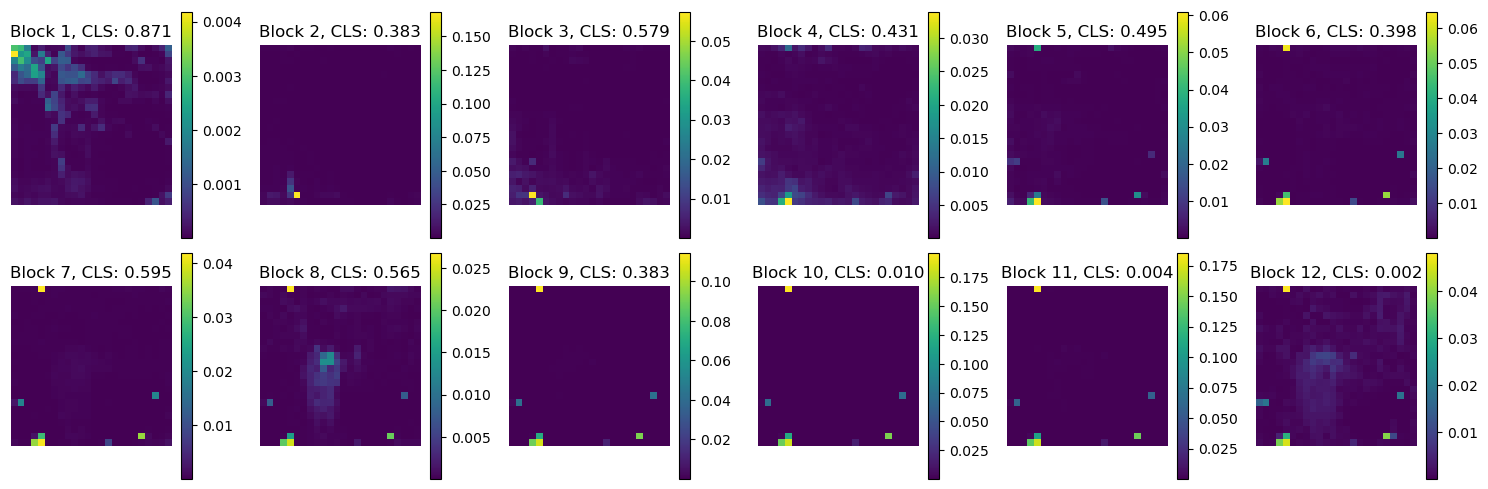

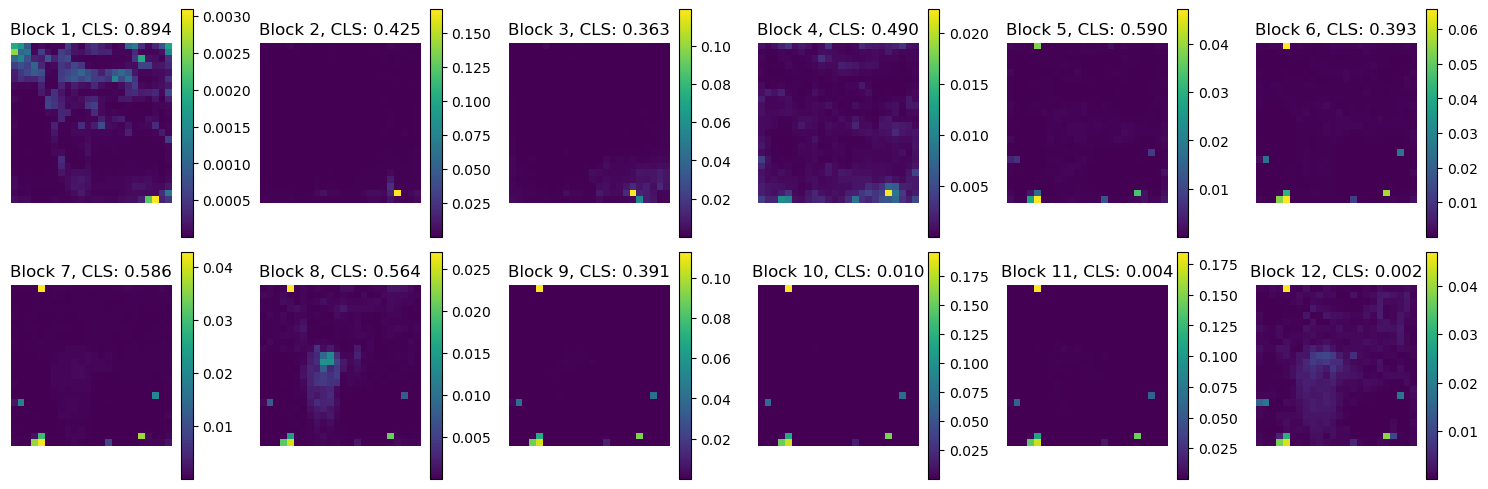

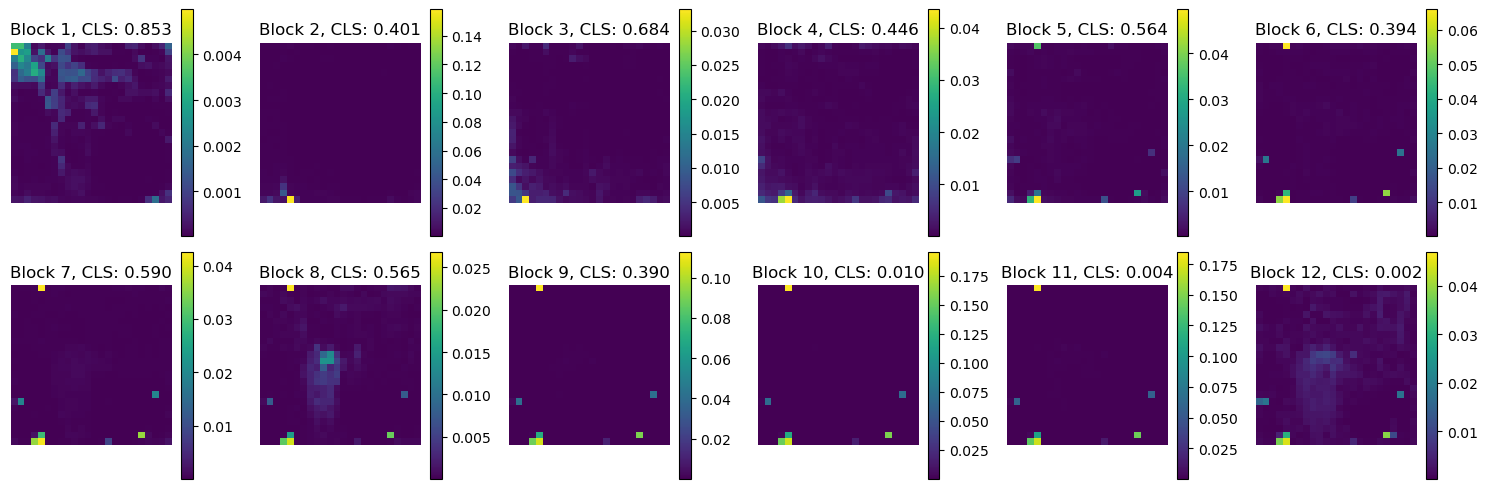

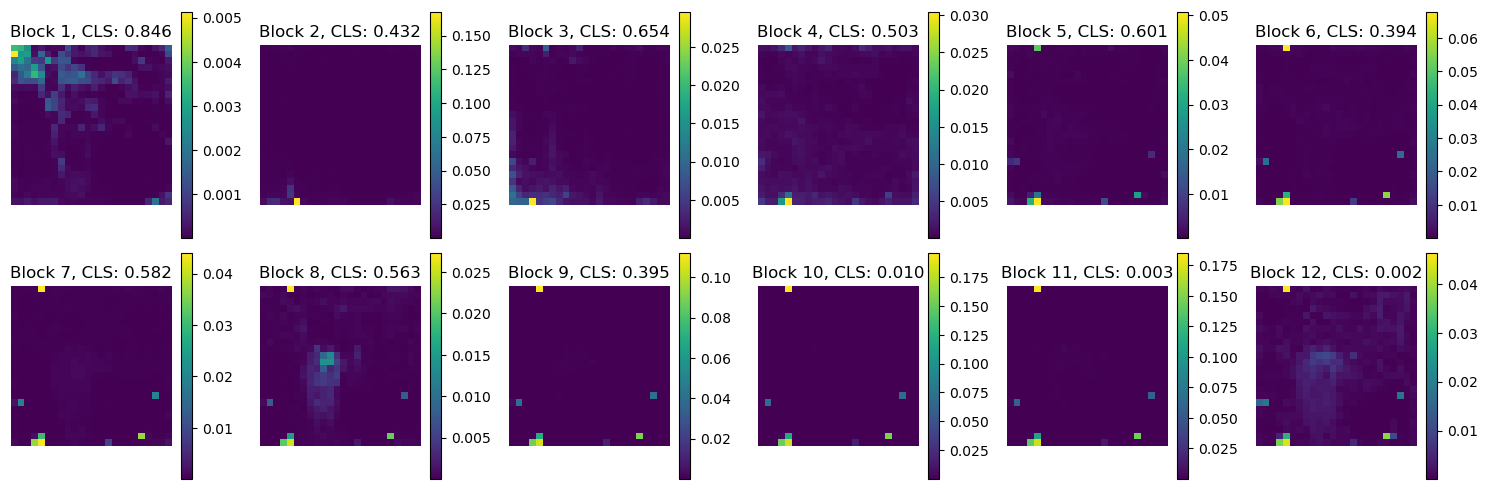

In [13]:
for x in intersection[0]:
    show_attn_progression(chosen_model, token = x)

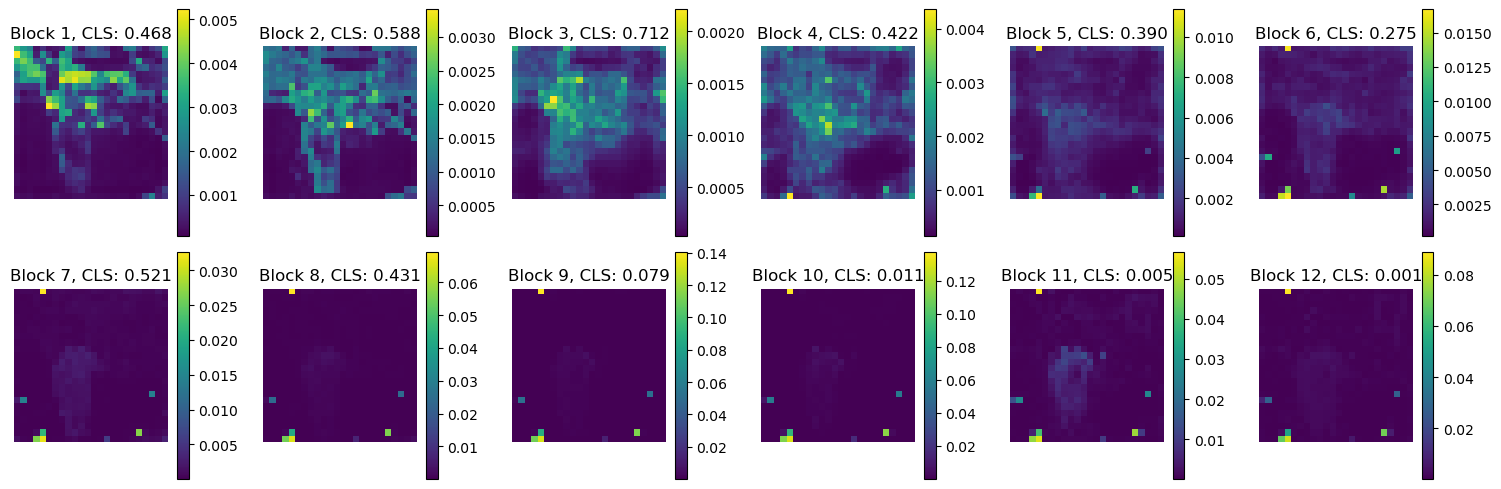

In [14]:
show_attn_progression(chosen_model, token = 'cls')

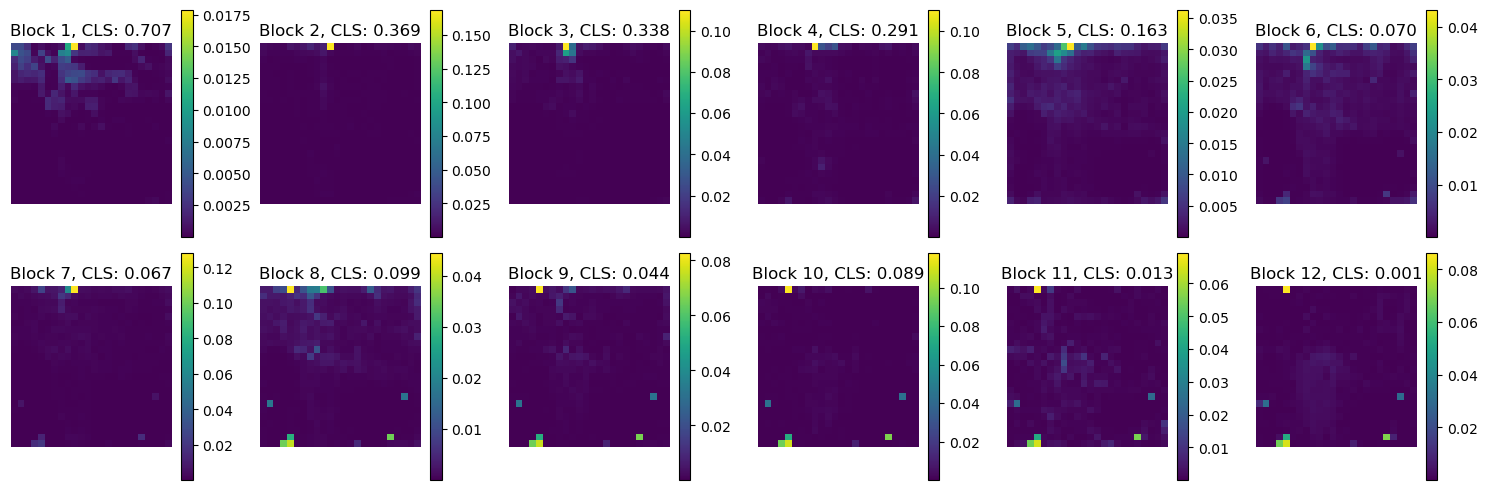

In [15]:
show_attn_progression(chosen_model, token = 9)

### Training logistic regression on high-norm and normal patches (CIFAR10)

In [23]:
use_mps = False
train_subset_size = 1500
test_subset_size = 400
batch_size = 16

if use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [35]:
# logistic regression norm-normal
print("Loading CIFAR-10 dataset...")
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

print(f"Creating subsets: {train_subset_size} training images, {test_subset_size} testing images...")
train_indices = torch.randperm(len(train_dataset))[:train_subset_size]
test_indices = torch.randperm(len(test_dataset))[:test_subset_size]

train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
print("Subsets and DataLoaders ready.")

print(f"\nLoading DeiT {model_size.upper()} model...")
model = chosen_model
model.to(device)
model.eval()
print(f"DeiT {model_size.upper()} model loaded and ready.")

Loading CIFAR-10 dataset...
Files already downloaded and verified
Files already downloaded and verified
Creating subsets: 100 training images, 400 testing images...
Subsets and DataLoaders ready.

Loading DeiT SMALL model...
DeiT SMALL model loaded and ready.


In [29]:
# Extract Patch Embeddings and Norms
high_norm_tokens = []
normal_tokens = []
labels_high = []  
labels_normal = [] 

print("Extracting patch embeddings...")
for batch_idx, (images, targets) in enumerate(train_loader):
    images = images.to(device)

    with torch.no_grad():
        model(images)
        # features = model.block_output['final']
        features = model.block_output['block11']
        
        patch_features = features[:, 1:, :]  
        norms = torch.norm(patch_features, dim=-1).cpu().numpy()

        for i in range(images.size(0)):  
            single_patch_features = patch_features[i]
            single_norms = norms[i]

            single_norms_tensor = torch.tensor(single_norms)
            top_tokens = torch.argsort(single_norms_tensor, descending=True)[:10].numpy()
            high_indices = np.where(single_norms > single_norms[top_tokens[-1]])[0]
            normal_indices = np.where(single_norms <= single_norms[top_tokens[-1]])[0]

            if high_indices.size > 0:
                high_norm_token = single_patch_features[high_indices[np.random.randint(len(high_indices))], :].cpu().numpy()
                high_norm_tokens.append(high_norm_token)
                labels_high.append(targets[i].item())

            if normal_indices.size > 0:
                normal_token = single_patch_features[normal_indices[np.random.randint(len(normal_indices))], :].cpu().numpy()
                normal_tokens.append(normal_token)
                labels_normal.append(targets[i].item())
    
    print(f"Processed batch {batch_idx + 1}/{len(train_loader)}")

print("Patch embedding extraction complete.")

print("Preparing datasets for Logistic Regression...")
X_high = np.array(high_norm_tokens)
X_normal = np.array(normal_tokens)
y_high = np.array(labels_high)
y_normal = np.array(labels_normal)

print(len(X_high), len(X_normal))
print(len(y_high), len(y_normal))

print("Splitting data into training and testing sets...")
X_high_train, X_high_test, y_high_train, y_high_test = train_test_split(X_high, y_high, test_size=0.2, random_state=42)
X_normal_train, X_normal_test, y_normal_train, y_normal_test = train_test_split(X_normal, y_normal, test_size=0.2, random_state=42)

Extracting patch embeddings...
Processed batch 1/94
Processed batch 2/94
Processed batch 3/94
Processed batch 4/94
Processed batch 5/94
Processed batch 6/94
Processed batch 7/94
Processed batch 8/94
Processed batch 9/94
Processed batch 10/94
Processed batch 11/94
Processed batch 12/94
Processed batch 13/94
Processed batch 14/94
Processed batch 15/94
Processed batch 16/94
Processed batch 17/94
Processed batch 18/94
Processed batch 19/94
Processed batch 20/94
Processed batch 21/94
Processed batch 22/94
Processed batch 23/94
Processed batch 24/94
Processed batch 25/94
Processed batch 26/94
Processed batch 27/94
Processed batch 28/94
Processed batch 29/94
Processed batch 30/94
Processed batch 31/94
Processed batch 32/94
Processed batch 33/94
Processed batch 34/94
Processed batch 35/94
Processed batch 36/94
Processed batch 37/94
Processed batch 38/94
Processed batch 39/94
Processed batch 40/94
Processed batch 41/94
Processed batch 42/94
Processed batch 43/94
Processed batch 44/94
Processed 

In [30]:
print("Training Logistic Regression classifiers...")
clf_high = LogisticRegression(max_iter=1000).fit(X_high_train, y_high_train)
print("High-Norm Token classifier trained.")

clf_normal = LogisticRegression(max_iter=1000).fit(X_normal_train, y_normal_train)
print("Normal Token classifier trained.")

print("Evaluating classifiers...")
high_acc = accuracy_score(y_high_test, clf_high.predict(X_high_test))
normal_acc = accuracy_score(y_normal_test, clf_normal.predict(X_normal_test))

print(f"High-Norm Token Accuracy: {high_acc:.4f}")
print(f"Normal Token Accuracy: {normal_acc:.4f}")

Training Logistic Regression classifiers...
High-Norm Token classifier trained.
Normal Token classifier trained.
Evaluating classifiers...
High-Norm Token Accuracy: 0.8467
Normal Token Accuracy: 0.7867


### Cosine similarity between high-norm/normal patches and their neighbours

In [33]:
# NOTE: we base it on just one image, is it ok/reliable? (though in the paper they do it in the same manner I think, judging by the density values)
embedding = chosen_model.patch_embed(img).squeeze(0)
top_norm = top_norm_tokens(chosen_model)[0, :10]

In [34]:
all_tokens = dict()
for x in range(24 * 24):
    emb = embedding[x].detach()
    right = embedding[(x + 1) % (24 * 24)]
    left = embedding[x - 1]
    up = embedding[x - 24]
    down = embedding[(x + 24) % (24 * 24)]

    cos_sim = torch.nn.CosineSimilarity(dim=0)
    mean_sim = (
        cos_sim(emb, right) + cos_sim(emb, left) + cos_sim(emb, up) + cos_sim(emb, down)
    ) / 4

    all_tokens[x] = mean_sim.detach().numpy()

In [35]:
top_norm_keys = set(top_norm)
top_norm_similarities = [all_tokens[key] for key in top_norm_keys]

not_top_norm_keys = set(all_tokens.keys()) - top_norm_keys
not_top_norm_similarities = [all_tokens[key] for key in not_top_norm_keys]

top_norm_similarities = [float(similarity) for similarity in top_norm_similarities]
not_top_norm_similarities = [
    float(similarity) for similarity in not_top_norm_similarities
]

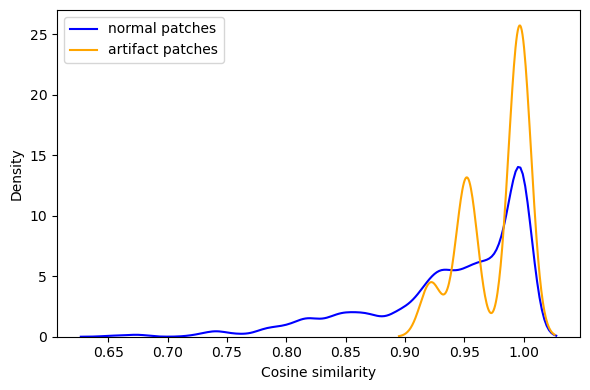

In [36]:
plot_similarity_density(top_norm_similarities, not_top_norm_similarities)

### Training linear regression on high-norm and normal patches to predict patch position (CIFAR10)

In [37]:
from torch.utils.data import Subset, DataLoader
from torchvision import transforms
import torchvision

# logistic regression norm-normal 
print("Loading CIFAR-10 dataset...")
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_subset_size = 1000
test_subset_size = 10
print(f"Creating subsets: {train_subset_size} training images, {test_subset_size} testing images...")
train_indices = torch.randperm(len(train_dataset))[:train_subset_size]
test_indices = torch.randperm(len(test_dataset))[:test_subset_size]
train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

batch_size = 16
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
print("Subsets and DataLoaders ready.")

print("Loading model...")
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps')
model = chosen_model
model.to(device)
model.eval()
print("Model loaded and ready.")

Loading CIFAR-10 dataset...
Files already downloaded and verified
Files already downloaded and verified
Creating subsets: 1000 training images, 10 testing images...
Subsets and DataLoaders ready.
Loading model...
Model loaded and ready.


In [38]:
# put all elements of the train loader in a single ndarray
print("Extracting patch embeddings...")
patch_embeddings = dict()
patch_embeddings = dict()
artifact_indices = dict()
total_count = dict()
for batch_idx, (images, targets) in enumerate(train_loader):
    images = images.to(device)
    with torch.no_grad():
        chosen_model(images)
    for block in range(12):
        if block not in patch_embeddings:
            patch_embeddings[block] = []
        patch_embeddings[block].append(chosen_model.block_output[f'block{block}'][:,1:,:].cpu().numpy())
        artifacts = top_norm_tokens(chosen_model, block = block)[:,:10]

        for i in range(images.size(0)):
            if block not in artifact_indices:
                artifact_indices[block] = []
            artifact_indices[block].append(artifacts[i])
            for artifact in artifacts[i]:
                if artifact not in total_count:
                    total_count[artifact] = 0
                total_count[artifact] += 1

            

            
    print(f"Processed batch {batch_idx + 1}/{len(train_loader)}")

for block in range(12):
    patch_embeddings[block] = np.concatenate(patch_embeddings[block], axis=0)

print("Patch embeddings extracted.")


Extracting patch embeddings...
Processed batch 1/63
Processed batch 2/63
Processed batch 3/63
Processed batch 4/63
Processed batch 5/63
Processed batch 6/63
Processed batch 7/63
Processed batch 8/63
Processed batch 9/63
Processed batch 10/63
Processed batch 11/63
Processed batch 12/63
Processed batch 13/63
Processed batch 14/63
Processed batch 15/63
Processed batch 16/63
Processed batch 17/63
Processed batch 18/63
Processed batch 19/63
Processed batch 20/63
Processed batch 21/63
Processed batch 22/63
Processed batch 23/63
Processed batch 24/63
Processed batch 25/63
Processed batch 26/63
Processed batch 27/63
Processed batch 28/63
Processed batch 29/63
Processed batch 30/63
Processed batch 31/63
Processed batch 32/63
Processed batch 33/63
Processed batch 34/63
Processed batch 35/63
Processed batch 36/63
Processed batch 37/63
Processed batch 38/63
Processed batch 39/63
Processed batch 40/63
Processed batch 41/63
Processed batch 42/63
Processed batch 43/63
Processed batch 44/63
Processed 

In [39]:
len(total_count.keys())

576

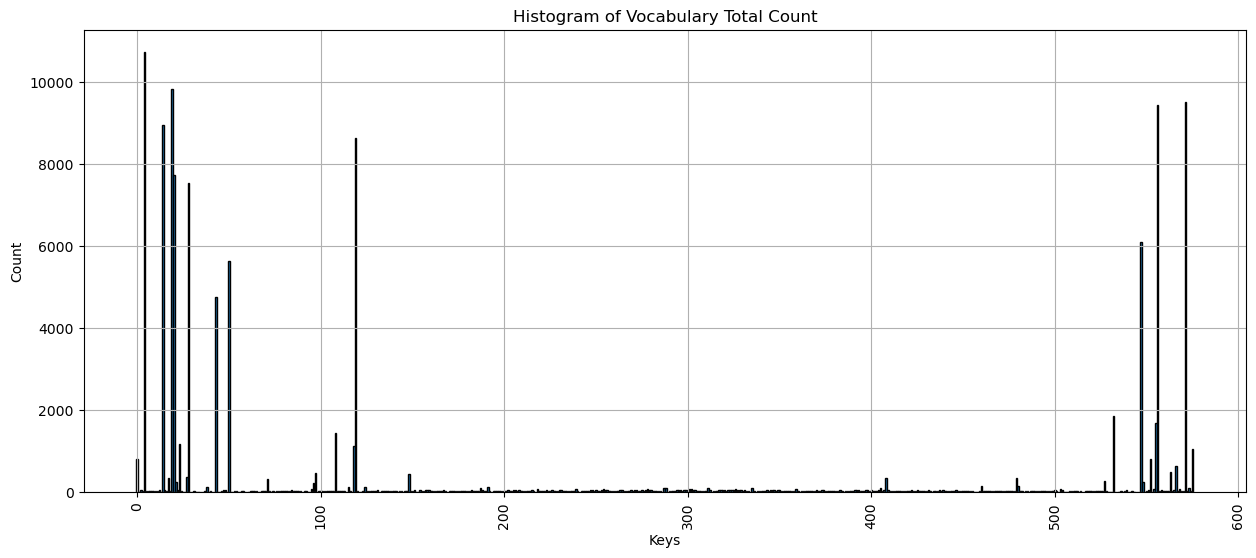

In [40]:
# Extract the keys and values from the total_count dictionary
keys = list(total_count.keys())
values = list(total_count.values())

# Plot the histogram
plt.figure(figsize=(15, 6))
plt.bar(keys, values, edgecolor='black')
plt.xlabel('Keys')
plt.ylabel('Count')
plt.title('Histogram of Vocabulary Total Count')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

y = np.array(range(576))
y = np.tile(y, 1000)
#X = patch_embeddings[block].reshape(-1, patch_embeddings[block].shape[-1])
#indices = np.random.choice(X.shape[0], 10 * 1000, replace=False)

accuracy_full = dict()
accuracy_artifact = dict()
accuracy_no_artifact = dict()


for block in range(12):
    print(f"Training Linear Regression for block {block}...")
    X = patch_embeddings[block].reshape(-1, patch_embeddings[block].shape[-1])
    indices = np.random.choice(X.shape[0], int(576 * 1000 / 10), replace=False)
    X_test = X[indices]
    y_test = y[indices]
    no_indices = [index for index in range(X.shape[0]) if index not in indices]
    X_train = X[no_indices]
    y_train = y[no_indices]

    X_test_artifact = []
    y_test_artifact = []
    X_train_artifact = []
    y_train_artifact = []

    no_artifact_indices = list(indices.copy())

    for index, x in enumerate(X_test):
        image_number = indices[index] // 576
        artifact_tokens = artifact_indices[block][image_number]
        if indices[index] % 576 in artifact_tokens:
            X_test_artifact.append(x)
            y_test_artifact.append(y_test[index])
            no_artifact_indices.remove(indices[index])

    X_test_artifact = np.array(X_test_artifact)
    y_test_artifact = np.array(y_test_artifact)
    X_test_no_artifact = X[no_artifact_indices]
    y_test_no_artifact = y[no_artifact_indices]

    # no_artifact_indices = list(no_indices.copy())

    # for index, x in enumerate(X_train):
    #     image_number = no_indices[index] // 576
    #     artifact_tokens = artifact_indices[block][image_number]
    #     if no_indices[index] % 576 in artifact_tokens:
    #         X_train_artifact.append(x)
    #         y_train_artifact.append(y_train[index])
    #         no_artifact_indices.remove(no_indices[index])
        
    

    # X_train_no_artifact = X[no_artifact_indices]
    # y_train_no_artifact = y[no_artifact_indices]
    # X_train_artifact = np.array(X_train_artifact)
    # y_train_artifact = np.array(y_train_artifact)


    # reg_no_artifact = LinearRegression().fit(X_train_no_artifact, y_train_no_artifact)
    # reg_artifact = LinearRegression().fit(X_train_artifact, y_train_artifact)
    reg_artifact = LinearRegression().fit(X_train, y_train)
    reg_no_artifact = LinearRegression().fit(X_train, y_train)

    y_pred_artifact = reg_artifact.predict(X_test_artifact)
    y_pred_no_artifact = reg_no_artifact.predict(X_test_no_artifact)


    y_pred_artifact = np.clip(y_pred_artifact, 0, 575)
    y_pred_no_artifact = np.clip(y_pred_no_artifact, 0, 575)

    accuracy_artifact[block] = np.mean(np.round(y_pred_artifact) == y_test_artifact)
    accuracy_no_artifact[block] = np.mean(np.round(y_pred_no_artifact) == y_test_no_artifact)
    print(f"Block {block} Artifact Accuracy: {accuracy_artifact[block]:.4f}, No Artifact Accuracy: {accuracy_no_artifact[block]:.4f}")
    print('Used artifact tokens:', 'Train = ',len(y_train_artifact), 'Test = ', len(y_test_artifact))



Training Linear Regression for block 0...
Block 0 Artifact Accuracy: 0.1322, No Artifact Accuracy: 0.0970
Used artifact tokens: Train =  0 Test =  1029
Training Linear Regression for block 1...
Block 1 Artifact Accuracy: 0.0686, No Artifact Accuracy: 0.0767
Used artifact tokens: Train =  0 Test =  1020
Training Linear Regression for block 2...
Block 2 Artifact Accuracy: 0.0316, No Artifact Accuracy: 0.0602
Used artifact tokens: Train =  0 Test =  1013
Training Linear Regression for block 3...
Block 3 Artifact Accuracy: 0.0058, No Artifact Accuracy: 0.0397
Used artifact tokens: Train =  0 Test =  1026
Training Linear Regression for block 4...
Block 4 Artifact Accuracy: 0.0000, No Artifact Accuracy: 0.0165
Used artifact tokens: Train =  0 Test =  976
Training Linear Regression for block 5...
Block 5 Artifact Accuracy: 0.0000, No Artifact Accuracy: 0.0065
Used artifact tokens: Train =  0 Test =  1011
Training Linear Regression for block 6...
Block 6 Artifact Accuracy: 0.0000, No Artifact 

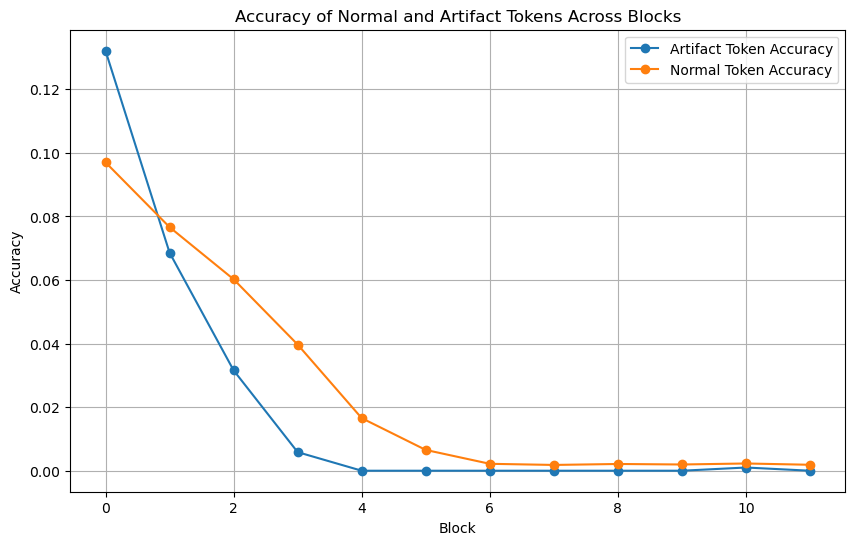

In [42]:
# Extracting values from the dictionaries
blocks = list(accuracy_artifact.keys())
artifact_accuracies = list(accuracy_artifact.values())
no_artifact_accuracies = list(accuracy_no_artifact.values())

# Plotting the accuracies
plt.figure(figsize=(10, 6))
plt.plot(blocks, artifact_accuracies, label='Artifact Token Accuracy', marker='o')
plt.plot(blocks, no_artifact_accuracies, label='Normal Token Accuracy', marker='o')
plt.xlabel('Block')
plt.ylabel('Accuracy')
plt.title('Accuracy of Normal and Artifact Tokens Across Blocks')
plt.legend()
plt.grid(True)
plt.show()

### Patch norm proportion across layers

In [43]:
print("Loading CIFAR-10 dataset...")
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

train_subset_size = 100

print(f"Creating subsets: {train_subset_size} training images...")
train_indices = torch.randperm(len(train_dataset))[:train_subset_size]

train_subset = Subset(train_dataset, train_indices)

batch_size = 16
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

print("Subsets and DataLoaders ready.")

print("Loading model...")
model = chosen_model
model.eval()
print("Model loaded and ready.")

Loading CIFAR-10 dataset...
Files already downloaded and verified
Creating subsets: 100 training images...
Subsets and DataLoaders ready.
Loading model...
Model loaded and ready.


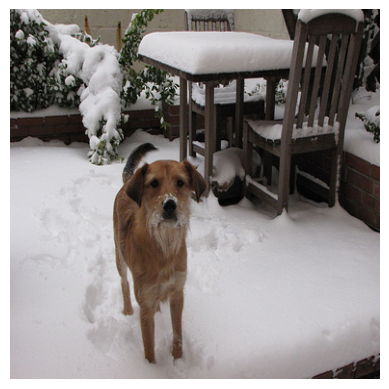

In [44]:
# either run this
# for images, targets in train_loader:
#     image = images[0]
#     break

# chosen_model(image.unsqueeze(0))
# plot_image(image)

################################################################################
# or this
model = model.to("cpu")
model(img)
plot_image(img.squeeze(0))

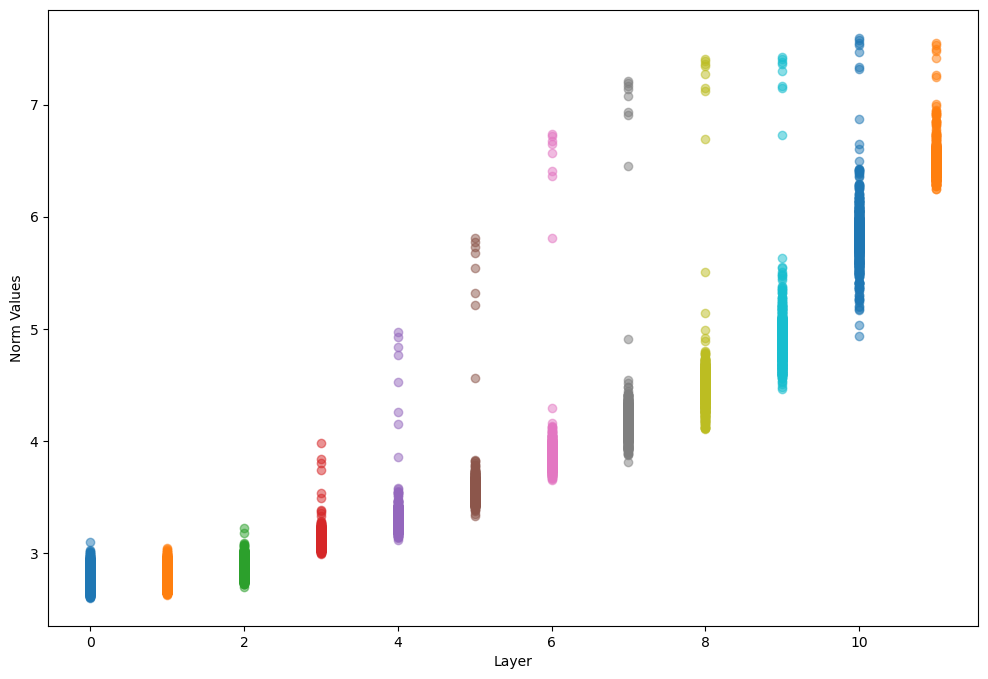

In [24]:
layer_norms = norm_per_layer(model)

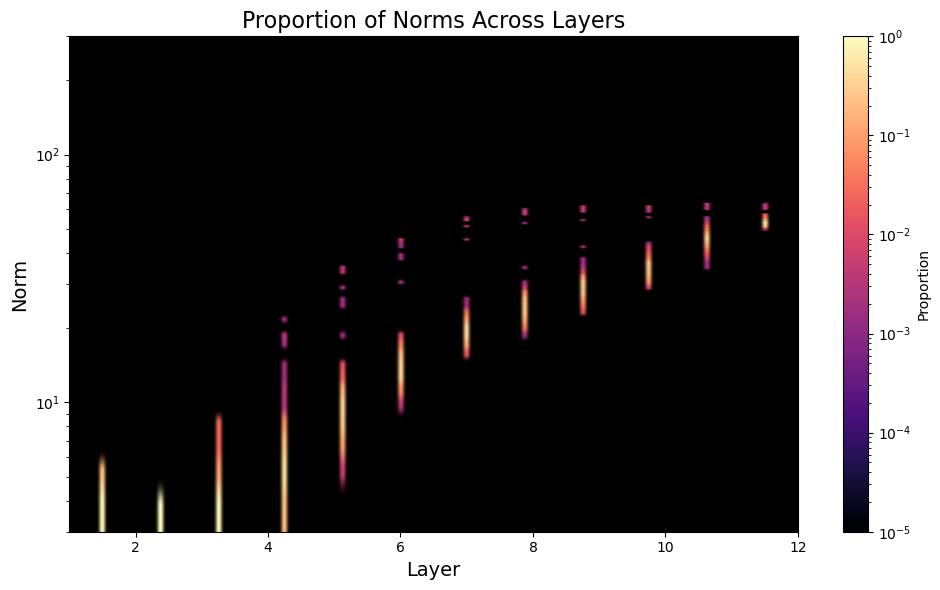

In [25]:
plot_norm_proportions(layer_norms)